# 概要
このノートブックでは, 最適化問題用のライブラリcvxoptを用いて

各種SVMを実装し, 比較を行う.

In [1]:
import cvxopt
from cvxopt import matrix
import numpy as np
from sklearn.metrics.pairwise import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#データの生成
np.random.seed(0)
data1 = np.random.randn(100, 2)+np.array([2,4])
data2 = np.random.randn(100, 2)+np.array([4,2])
data = np.r_[data1, data2]
y = np.r_[np.ones(100), (-1)*np.ones(100)]

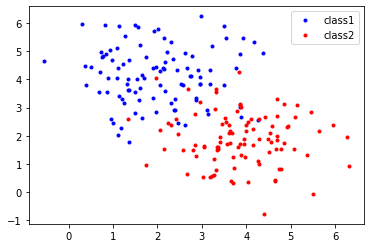

In [3]:
#データ分布の可視化
plt.figure()
plt.plot(data1[:,0], data1[:,1], 'b.', label="class1")
plt.plot(data2[:,0], data2[:,1], 'r.', label="class2")
plt.legend()
plt.show()
plt.close()

## L1-SVM (線形)
-------------------------------------------
**最適化問題**

L1-SVMは次の最適化問題で定義される.


\begin{align}
\mathrm{min}\quad &\frac{1}{2} \| \boldsymbol{w} \|^2+C \sum_{i=1}^M \xi_i \\
\mathrm{s.t} \quad &y_i D(\boldsymbol{x}_i ) \geq 1- \xi_i,\quad \xi_i \geq 0
\end{align}


ただし,
SVMの決定関数$D(\boldsymbol{x}_i)$は


\begin{align}
D(\boldsymbol{x}) = \boldsymbol{w}^\top \boldsymbol{x}+b
\end{align}


である.


この最適化問題にラグランジュ未定乗数$\alpha_i (i=1, \cdots, M)$を導入すると,


\begin{align}
\mathrm{max}\quad &\sum_{i=1}^M \alpha_i - \frac{1}{2} \sum_{i, j=1}^M \alpha_i \alpha_j y_i y_j \boldsymbol{x}_i^\top \boldsymbol{x}_j \\
\mathrm{s.t.} \quad &\sum_{i=1}^M \alpha_i y_i = 0,\quad 0 \leq \alpha_i \leq C 
\end{align}

ここで, $\boldsymbol{w} = \sum_{i \in SV} \alpha_i y_i \boldsymbol{x}_i$である.

---------------------------------------------------------


**SVについて**

$\alpha_i=0$に対応する$x_i$は正しく識別できている教師データ(非SV)

$0<\alpha_i<C$に対応する$x_i$は上限に達していないサポートベクトル ($D(x) = \pm 1$上)

$\alpha_i=C$に対応する$x_i$は上限に達したサポートベクトル

----------------------------------------------------

**cvxoptについて**

cvxoptのqpは以下の最適化問題を解く.

\begin{align}
\mathrm{min}\quad &\frac{1}{2} \boldsymbol{\alpha}^\top P \boldsymbol{\alpha} -\boldsymbol{q}^\top \boldsymbol{\alpha}\\
\mathrm{s.t.} \quad &A\boldsymbol{\alpha} = \boldsymbol{b}, \quad G\boldsymbol{\alpha} \leq \boldsymbol{h} 
\end{align}

-----------------------------------------------------

In [4]:
class L1SVM(object):
    def __init__(self, C=10):
        self.C = C
        cvxopt.solvers.options['abstol']=1e-15
        cvxopt.solvers.options['reltol']=1e-15
        cvxopt.solvers.options['feastol']=1e-15
        cvxopt.solvers.options['maxiters']=500
        
    def fit(self, train_X, train_Y):
        #内積行列を作成
        K = train_X @ train_X.T
        
        #cvxopt用の変数
        P = matrix(K*train_Y.reshape(1,-1)*train_Y.reshape(-1,1), K.shape ,'d')
        q = matrix((-1)*np.ones(K.shape[0]).reshape(-1,1),(K.shape[0],1) ,'d')
        A = matrix(train_Y.reshape(1,-1),(1,K.shape[0]),'d')
        b = matrix(np.array([0]),(1,1),'d')
        G1 = (-1)*np.identity(K.shape[0])
        h1 = np.zeros(K.shape[0]).reshape(-1,1)
        G2 = np.identity(K.shape[0])
        h2 = self.C*np.ones(K.shape[0]).reshape(-1,1)
        
        G = matrix(np.r_[G1, G2],(2*K.shape[0], K.shape[0]), 'd')
        h = matrix(np.r_[h1, h2],(2*K.shape[0],1),'d')

        self.sol = cvxopt.solvers.qp(P=P, q=q, A=A, b=b, G=G, h=h)
        self.alpha = np.array(self.sol['x']).reshape(-1)
        if(self.C > 1):
            idx = np.where(self.alpha<1e-3)
        else:
            idx = np.where(self.alpha<self.C*1e-4)
        self.alpha[idx] = 0
        self.sv_index = np.where(self.alpha>0)
        self.sv = train_X[self.sv_index]
        self.sv_label = train_Y[self.sv_index]
        self.w = np.sum([self.alpha[i]*train_Y[i]*train_X[i] for i in range(len(train_Y))], axis=0)
        self.b = np.sum([self.sv_label[i]-self.w.reshape(1,-1) @ self.sv[i].T for i in range(len(self.sv_label))])/len(self.sv_label)
        
    def decision_function(self,X):
        return X @ self.w.reshape(-1,1) +np.ones((X.shape[0],1))*self.b
    
    def predict(self, X):
        D = self.decision_function(X)
        predict_y = np.ones(X.shape[0])
        predict_y[D.reshape(-1)<0]=-1
        return predict_y
    
    def score(self, X, Y):
        predict_y = self.predict(X)
        return 100*np.sum(Y==predict_y)/len(Y)

In [5]:
#学習
l1svm = L1SVM(C=10)
l1svm.fit(data, y)
print(f'score : {l1svm.score(data,y)}%')

     pcost       dcost       gap    pres   dres
 0: -3.4241e+02 -1.5013e+04  4e+04  8e-01  6e-13
 1: -2.4118e+02 -4.3551e+03  6e+03  6e-02  5e-13
 2: -2.4102e+02 -9.3656e+02  8e+02  7e-03  4e-13
 3: -2.9332e+02 -5.5723e+02  3e+02  2e-03  4e-13
 4: -2.9745e+02 -5.1075e+02  2e+02  1e-03  4e-13
 5: -3.1346e+02 -5.0754e+02  2e+02  8e-04  4e-13
 6: -3.3007e+02 -4.4283e+02  1e+02  4e-04  4e-13
 7: -3.4090e+02 -4.1993e+02  8e+01  2e-04  4e-13
 8: -3.5207e+02 -3.8857e+02  4e+01  2e-16  5e-13
 9: -3.6073e+02 -3.7536e+02  1e+01  6e-14  5e-13
10: -3.6434e+02 -3.6925e+02  5e+00  1e-15  5e-13
11: -3.6570e+02 -3.6727e+02  2e+00  2e-13  6e-13
12: -3.6643e+02 -3.6645e+02  2e-02  3e-13  5e-13
13: -3.6644e+02 -3.6644e+02  2e-04  3e-13  6e-13
14: -3.6644e+02 -3.6644e+02  2e-06  3e-13  6e-13
15: -3.6644e+02 -3.6644e+02  2e-08  2e-13  6e-13
16: -3.6644e+02 -3.6644e+02  2e-10  5e-14  6e-13
17: -3.6644e+02 -3.6644e+02  2e-12  1e-13  6e-13
Terminated (singular KKT matrix).
score : 92.0%


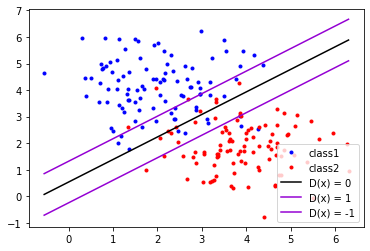

In [6]:
#データ分布の可視化
t = np.linspace(start=min(data[:,0]), stop = max(data[:,0]), num=50)
plt.figure()
plt.plot(data1[:,0], data1[:,1], 'b.', label="class1")
plt.plot(data2[:,0], data2[:,1], 'r.', label="class2")
plt.plot(t, (0-l1svm.b-l1svm.w[0]*t)/l1svm.w[1], 'black',label='D(x) = 0')
plt.plot(t, (1-l1svm.b-l1svm.w[0]*t)/l1svm.w[1], 'darkviolet',label='D(x) = 1')
plt.plot(t, (-1-l1svm.b-l1svm.w[0]*t)/l1svm.w[1], 'darkviolet',label='D(x) = -1')
plt.legend()
plt.show()
plt.close()

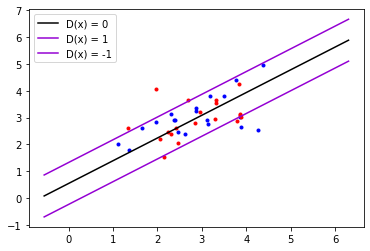

In [7]:
#サポートベクトルの可視化
t = np.linspace(start=min(data[:,0]), stop = max(data[:,0]), num=50)
plt.figure()
idx1 = np.where(l1svm.sv_label==1)
idx2 = np.where(l1svm.sv_label==-1)
plt.plot(l1svm.sv[idx1, 0], l1svm.sv[idx1, 1], 'b.')
plt.plot(l1svm.sv[idx2, 0], l1svm.sv[idx2, 1], 'r.')
plt.plot(t, (0-l1svm.b-l1svm.w[0]*t)/l1svm.w[1], 'black',label='D(x) = 0')
plt.plot(t, (1-l1svm.b-l1svm.w[0]*t)/l1svm.w[1], 'darkviolet',label='D(x) = 1')
plt.plot(t, (-1-l1svm.b-l1svm.w[0]*t)/l1svm.w[1], 'darkviolet',label='D(x) = -1')
plt.legend()
plt.show()
plt.close()

計算の誤差のせいで上限に達していないSVが$D=\pm 1$にピッタリ乗っていないみたいです

## L2-SVM (線形)
-------------------------------------------
**最適化問題**

L2-SVMは次の最適化問題で定義される.


\begin{align}
\mathrm{min}\quad &\frac{1}{2} \| \boldsymbol{w} \|^2+\frac{C}{2} \sum_{i=1}^M \xi_i^2 \\
\mathrm{s.t} \quad &y_i D(\boldsymbol{x}_i ) \geq 1- \xi_i
\end{align}


ただし,
SVMの決定関数$D(\boldsymbol{x}_i)$は


\begin{align}
D(\boldsymbol{x}) = \boldsymbol{w}^\top \boldsymbol{x}+b
\end{align}


である.


この最適化問題にラグランジュ未定乗数$\alpha_i (i=1, \cdots, M)$を導入すると,


\begin{align}
\mathrm{max}\quad &\sum_{i=1}^M \alpha_i - \frac{1}{2} \sum_{i, j=1}^M \alpha_i \alpha_j y_i y_j (\boldsymbol{x}_i^\top \boldsymbol{x}_j+\frac{\delta_{ij}}{C}) \\
\mathrm{s.t.} \quad &\sum_{i=1}^M \alpha_i y_i = 0,\quad 0 \leq \alpha_i
\end{align}

ここで, $\boldsymbol{w} = \sum_{i \in SV} \alpha_i y_i \boldsymbol{x}_i$である.

---------------------------------------------------------


**SVについて**

$\alpha_i=0$に対応する$x_i$は正しく識別できている教師データ(非SV)

$0<\alpha_i$に対応する$x_i$はサポートベクトル 

----------------------------------------------------

**cvxoptについて**

cvxoptのqpは以下の最適化問題を解く.

\begin{align}
\mathrm{min}\quad &\frac{1}{2} \boldsymbol{\alpha}^\top P \boldsymbol{\alpha} -\boldsymbol{q}^\top \boldsymbol{\alpha}\\
\mathrm{s.t.} \quad &A\boldsymbol{\alpha} = \boldsymbol{b}, \quad G\boldsymbol{\alpha} \leq \boldsymbol{h} 
\end{align}

-----------------------------------------------------

In [8]:
class L2SVM(object):
    def __init__(self, C=10):
        self.C = C
        cvxopt.solvers.options['abstol']=1e-15
        cvxopt.solvers.options['reltol']=1e-15
        cvxopt.solvers.options['feastol']=1e-15
        cvxopt.solvers.options['maxiters']=500
        
    def fit(self, train_X, train_Y):
        #内積行列を作成
        K = train_X @ train_X.T+np.identity(train_X.shape[0])/self.C
        
        #cvxopt用の変数
        P = matrix(K*train_Y.reshape(1,-1)*train_Y.reshape(-1,1), K.shape ,'d')
        q = matrix((-1)*np.ones(K.shape[0]).reshape(-1,1),(K.shape[0],1) ,'d')
        A = matrix(train_Y.reshape(1,-1),(1,K.shape[0]),'d')
        b = matrix(np.array([0]),(1,1),'d')
        G1 = (-1)*np.identity(K.shape[0])
        h1 = np.zeros(K.shape[0]).reshape(-1,1)
        
        G = matrix(G1,(K.shape[0], K.shape[0]), 'd')
        h = matrix(h1,(K.shape[0],1),'d')

        self.sol = cvxopt.solvers.qp(P=P, q=q, A=A, b=b, G=G, h=h)
        self.alpha = np.array(self.sol['x']).reshape(-1)
        if(self.C > 1):
            idx = np.where(self.alpha<1e-3)
        else:
            idx = np.where(self.alpha<self.C*1e-4)
        self.alpha[idx] = 0
        self.sv_index = np.where(self.alpha>0)
        self.sv = train_X[self.sv_index]
        self.sv_label = train_Y[self.sv_index]
        self.w = np.sum([self.alpha[i]*train_Y[i]*train_X[i] for i in range(len(train_Y))], axis=0)
        self.b = np.sum([self.sv_label[i]-self.w.reshape(1,-1) @ self.sv[i].T for i in range(len(self.sv_label))])/len(self.sv_label)
        
    def decision_function(self,X):
        return X @ self.w.reshape(-1,1) +np.ones((X.shape[0],1))*self.b
    
    def predict(self, X):
        D = self.decision_function(X)
        predict_y = np.ones(X.shape[0])
        predict_y[D.reshape(-1)<0]=-1
        return predict_y
    
    def score(self, X, Y):
        predict_y = self.predict(X)
        return 100*np.sum(Y==predict_y)/len(Y)

In [9]:
#学習
l2svm = L2SVM(C=10)
l2svm.fit(data, y)
print(f'score : {l2svm.score(data,y)}%')

     pcost       dcost       gap    pres   dres
 0: -5.5809e+01 -1.4958e+02  9e+02  3e+01  3e+00
 1: -1.5884e+02 -3.0997e+02  5e+02  1e+01  1e+00
 2: -1.9577e+02 -3.2384e+02  2e+02  2e+00  2e-01
 3: -2.1635e+02 -2.5087e+02  4e+01  3e-01  3e-02
 4: -2.2799e+02 -2.3446e+02  7e+00  3e-02  3e-03
 5: -2.3135e+02 -2.3194e+02  6e-01  2e-03  2e-04
 6: -2.3174e+02 -2.3176e+02  2e-02  4e-05  4e-06
 7: -2.3176e+02 -2.3176e+02  4e-04  4e-07  4e-08
 8: -2.3176e+02 -2.3176e+02  1e-05  4e-09  4e-10
 9: -2.3176e+02 -2.3176e+02  1e-07  4e-11  4e-12
10: -2.3176e+02 -2.3176e+02  1e-09  4e-13  7e-13
11: -2.3176e+02 -2.3176e+02  1e-11  3e-13  8e-13
12: -2.3176e+02 -2.3176e+02  1e-13  8e-14  6e-13
13: -2.3176e+02 -2.3176e+02  1e-15  1e-14  7e-13
14: -2.3176e+02 -2.3176e+02  1e-17  4e-14  6e-13
15: -2.3176e+02 -2.3176e+02  1e-19  5e-14  7e-13
16: -2.3176e+02 -2.3176e+02  1e-21  5e-14  7e-13
17: -2.3176e+02 -2.3176e+02  1e-23  9e-14  7e-13
18: -2.3176e+02 -2.3176e+02  1e-25  1e-13  6e-13
19: -2.3176e+02 -2.31

205: -2.3176e+02 -2.3176e+02  3e-304  1e-08  2e+03
206: -2.3176e+02 -2.3176e+02  3e-306  1e-10  2e+01
207: -2.3176e+02 -2.3176e+02  3e-308  1e-12  7e-01
208: -2.3176e+02 -2.3176e+02  5e-304  1e-13  4e+00
209: -2.3176e+02 -2.3176e+02  5e-306  5e-14  6e-02
210: -2.3176e+02 -2.3176e+02  4e-305  9e-11  8e+02
211: -2.3176e+02 -2.3176e+02  4e-307  9e-13  8e+00
212: -2.3176e+02 -2.3176e+02  7e-304  5e-14  6e+01
213: -2.3176e+02 -2.3176e+02  7e-306  4e-14  8e-01
214: -2.3176e+02 -2.3176e+02  3e-305  1e-11  1e+03
215: -2.3176e+02 -2.3176e+02  3e-307  1e-13  1e+01
216: -2.3176e+02 -2.3176e+02  3e-304  7e-14  4e+01
217: -2.3176e+02 -2.3176e+02  3e-306  8e-14  8e-01
218: -2.3176e+02 -2.3176e+02  3e-304  7e-12  5e+02
219: -2.3176e+02 -2.3176e+02  3e-306  1e-13  5e+00
220: -2.3176e+02 -2.3176e+02  3e-304  6e-13  5e+02
221: -2.3176e+02 -2.3176e+02  3e-306  1e-13  5e+00
222: -2.3176e+02 -2.3176e+02  3e-305  5e-13  4e+02
223: -2.3176e+02 -2.3176e+02  3e-307  6e-14  4e+00
224: -2.3176e+02 -2.3176e+02  3

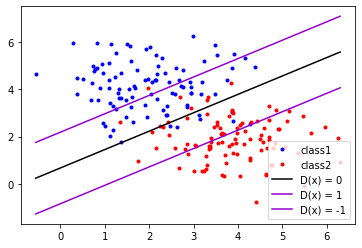

In [10]:
#データ分布の可視化
t = np.linspace(start=min(data[:,0]), stop = max(data[:,0]), num=50)
plt.figure()
plt.plot(data1[:,0], data1[:,1], 'b.', label="class1")
plt.plot(data2[:,0], data2[:,1], 'r.', label="class2")
plt.plot(t, (0-l2svm.b-l2svm.w[0]*t)/l2svm.w[1], 'black',label='D(x) = 0')
plt.plot(t, (1-l2svm.b-l2svm.w[0]*t)/l2svm.w[1], 'darkviolet',label='D(x) = 1')
plt.plot(t, (-1-l2svm.b-l2svm.w[0]*t)/l2svm.w[1], 'darkviolet',label='D(x) = -1')
plt.legend()
plt.show()
plt.close()

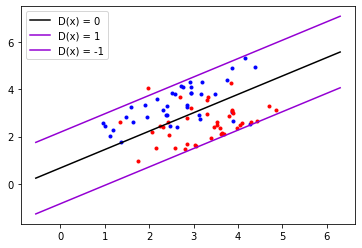

In [11]:
#サポートベクトルの可視化
t = np.linspace(start=min(data[:,0]), stop = max(data[:,0]), num=50)
plt.figure()
idx1 = np.where(l2svm.sv_label==1)
idx2 = np.where(l2svm.sv_label==-1)
plt.plot(l2svm.sv[idx1, 0], l2svm.sv[idx1, 1], 'b.')
plt.plot(l2svm.sv[idx2, 0], l2svm.sv[idx2, 1], 'r.')
plt.plot(t, (0-l2svm.b-l2svm.w[0]*t)/l2svm.w[1], 'black',label='D(x) = 0')
plt.plot(t, (1-l2svm.b-l2svm.w[0]*t)/l2svm.w[1], 'darkviolet',label='D(x) = 1')
plt.plot(t, (-1-l2svm.b-l2svm.w[0]*t)/l2svm.w[1], 'darkviolet',label='D(x) = -1')
plt.legend()
plt.show()
plt.close()

# ハードマージンSVM(非線形 : カーネル法)

-------------------------------------------
**最適化問題**

ハードマージンSVMは次の最適化問題で定義される.


\begin{align}
\mathrm{min}\quad &\frac{1}{2} \| \boldsymbol{w} \|^2 \\
\mathrm{s.t} \quad &y_i D(\boldsymbol{x}_i ) \geq 1
\end{align}


ただし,
SVMの決定関数$D(\boldsymbol{x}_i)$は


\begin{align}
D(\boldsymbol{x}) = \boldsymbol{w}^\top \boldsymbol{\phi}(\boldsymbol{x})+b
\end{align}


である.


この最適化問題にラグランジュ未定乗数$\alpha_i (i=1, \cdots, M)$を導入すると,


\begin{align}
\mathrm{max}\quad &\sum_{i=1}^M \alpha_i - \frac{1}{2} \sum_{i, j=1}^M \alpha_i \alpha_j y_i y_j K(\boldsymbol{x}_i, \boldsymbol{x}_j) \\
\mathrm{s.t.} \quad &\sum_{i=1}^M \alpha_i y_i = 0
\end{align}

ここで, $\boldsymbol{w} = \sum_{i \in SV} \alpha_i y_i \boldsymbol{x}_i$である.

---------------------------------------------------------


**SVについて**

$\alpha_i=0$に対応する$x_i$は正しく識別できている教師データ(非SV)

$0<\alpha_i<C$に対応する$x_i$は上限に達していないサポートベクトル ($D(x) = \pm 1$上)

$\alpha_i=C$に対応する$x_i$は上限に達したサポートベクトル

----------------------------------------------------

**cvxoptについて**

cvxoptのqpは以下の最適化問題を解く.

\begin{align}
\mathrm{min}\quad &\frac{1}{2} \boldsymbol{\alpha}^\top P \boldsymbol{\alpha} -\boldsymbol{q}^\top \boldsymbol{\alpha}\\
\mathrm{s.t.} \quad &A\boldsymbol{\alpha} = \boldsymbol{b}, \quad G\boldsymbol{\alpha} \leq \boldsymbol{h} 
\end{align}

-----------------------------------------------------

In [12]:
from sklearn.metrics.pairwise import linear_kernel, polynomial_kernel, rbf_kernel
class HSVM(object):
    def __init__(self, kernel='lienar', d=2, gamma=3.0):
        self.kernel = kernel
        self.d = d
        self.gamma=gamma
        
        cvxopt.solvers.options['abstol']=1e-15
        cvxopt.solvers.options['reltol']=1e-15
        cvxopt.solvers.options['feastol']=1e-15
        cvxopt.solvers.options['maxiters']=500
    
    def _set_kernel(self, X, Y=None):
        if(self.kernel=='rbf'):
            return rbf_kernel(X,Y,gamma=self.gamma)
        elif(self.kernel=='poly'):
            return polynomial_kernel(X,Y,degree=self.d, gamma=1, coef0=1)
        else:
            return linear_kernel(X,Y)
        
    def fit(self, train_X, train_Y):
        #内積行列を作成
        K = self._set_kernel(train_X)
        self.train_X=train_X
        self.train_Y=train_Y
        
        #cvxopt用の変数
        P = matrix(K*train_Y.reshape(1,-1)*train_Y.reshape(-1,1), K.shape ,'d')
        q = matrix((-1)*np.ones(K.shape[0]).reshape(-1,1),(K.shape[0],1) ,'d')
        A = matrix(train_Y.reshape(1,-1),(1,K.shape[0]),'d')
        b = matrix(np.array([0]),(1,1),'d')

        self.sol = cvxopt.solvers.qp(P=P, q=q, A=A, b=b)
        self.alpha = np.array(self.sol['x']).reshape(-1)
        idx = np.where(self.alpha<1e-3)
        self.alpha[idx] = 0
        self.sv_index = np.where(self.alpha>0)
        self.sv = train_X[self.sv_index]
        self.sv_label = train_Y[self.sv_index]
        self.b = np.sum(train_Y.reshape(-1,1)-(K*self.train_Y.reshape(1,-1))@self.alpha.reshape(-1,1), axis=0)/len(train_Y)
        
    def decision_function(self,X):
        return (self._set_kernel(X, self.train_X)*self.train_Y.reshape(1,-1))@self.alpha.reshape(-1,1) +np.ones((X.shape[0],1))*self.b
    
    def predict(self, X):
        D = self.decision_function(X)
        predict_y = np.ones(X.shape[0])
        predict_y[D.reshape(-1)<0]=-1
        return predict_y
    
    def score(self, X, Y):
        predict_y = self.predict(X)
        return 100*np.sum(Y==predict_y)/len(Y)

In [13]:
#学習
hsvm = HSVM(kernel='rbf', gamma=100)
hsvm.fit(data, y)
print(f'score : {hsvm.score(data,y)}%')

score : 100.0%


In [14]:
from matplotlib.colors import LinearSegmentedColormap

def set_sklearn_backgound(cls, x_r, y_r):
    N = 1000

    color_map = LinearSegmentedColormap.from_list("color_map", [
            (0.0, "#f59322"),
            (0.5, "#ffffff"),
            (1.0, "#0877bd"),])

    X, Y = np.meshgrid(np.linspace(*x_r, N), np.linspace(*y_r, N))
    X = np.hstack(X)
    Y = np.hstack(Y)
    Z=np.dstack((X, Y)).reshape(-1, 2)
    Z = cls.predict(Z).reshape(N,N)
    X = X.reshape((N, -1))
    Y = Y.reshape((N, -1))

    plt.pcolor(X, Y, Z, cmap=color_map)

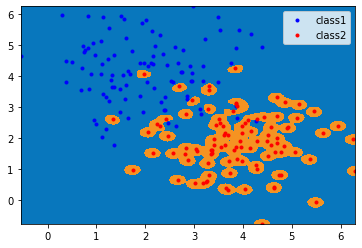

In [15]:
x_r = [min(data[:,0]), max(data[:,0])]
y_r = [min(data[:,1]), max(data[:,1])]
set_sklearn_backgound(hsvm, x_r, y_r)
plt.xlim(x_r)
plt.ylim(y_r)
t = np.linspace(start=min(data[:,0]), stop = max(data[:,0]), num=50)
plt.plot(data1[:,0], data1[:,1], 'b.', label="class1")
plt.plot(data2[:,0], data2[:,1], 'r.', label="class2")
plt.legend()
plt.show()
plt.close()

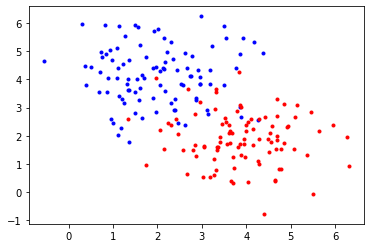

In [16]:
#サポートベクトルの可視化
t = np.linspace(start=min(data[:,0]), stop = max(data[:,0]), num=50)
plt.figure()
idx1 = np.where(hsvm.sv_label==1)
idx2 = np.where(hsvm.sv_label==-1)
plt.plot(hsvm.sv[idx1, 0], hsvm.sv[idx1, 1], 'b.')
plt.plot(hsvm.sv[idx2, 0], hsvm.sv[idx2, 1], 'r.')
plt.show()
plt.close()

# L1-SVM(非線形 : カーネル法)

In [17]:
class L1KSVM(object):
    def __init__(self, C=10, kernel='lienar', d=2, gamma=3.0):
        self.C = C
        self.kernel = kernel
        self.d = d
        self.gamma=gamma
        
        cvxopt.solvers.options['abstol']=1e-15
        cvxopt.solvers.options['reltol']=1e-15
        cvxopt.solvers.options['feastol']=1e-15
        cvxopt.solvers.options['maxiters']=500
        
    def _set_kernel(self, X, Y=None):
        if(self.kernel=='rbf'):
            return rbf_kernel(X,Y,gamma=self.gamma)
        elif(self.kernel=='poly'):
            return polynomial_kernel(X,Y,degree=self.d, gamma=1, coef0=1)
        else:
            return linear_kernel(X,Y)
        
    def fit(self, train_X, train_Y):
        #内積行列を作成
        K = self._set_kernel(train_X)
        self.train_X=train_X
        self.train_Y=train_Y
        
        #cvxopt用の変数
        P = matrix(K*train_Y.reshape(1,-1)*train_Y.reshape(-1,1), K.shape ,'d')
        q = matrix((-1)*np.ones(K.shape[0]).reshape(-1,1),(K.shape[0],1) ,'d')
        A = matrix(train_Y.reshape(1,-1),(1,K.shape[0]),'d')
        b = matrix(np.array([0]),(1,1),'d')
        G1 = (-1)*np.identity(K.shape[0])
        h1 = np.zeros(K.shape[0]).reshape(-1,1)
        G2 = np.identity(K.shape[0])
        h2 = self.C*np.ones(K.shape[0]).reshape(-1,1)
        
        G = matrix(np.r_[G1, G2],(2*K.shape[0], K.shape[0]), 'd')
        h = matrix(np.r_[h1, h2],(2*K.shape[0],1),'d')

        self.sol = cvxopt.solvers.qp(P=P, q=q, A=A, b=b, G=G, h=h)
        self.alpha = np.array(self.sol['x']).reshape(-1)
        if(self.C > 1):
            idx = np.where(self.alpha<1e-3)
        else:
            idx = np.where(self.alpha<self.C*1e-4)
        self.alpha[idx] = 0
        self.sv_index = np.where(self.alpha>0)
        self.sv = train_X[self.sv_index]
        self.sv_label = train_Y[self.sv_index]
        self.b = np.sum(train_Y.reshape(-1,1)-(K*self.train_Y.reshape(1,-1))@self.alpha.reshape(-1,1), axis=0)/len(train_Y)
        
    def decision_function(self,X):
        return (self._set_kernel(X, self.train_X)*self.train_Y.reshape(1,-1))@self.alpha.reshape(-1,1) +np.ones((X.shape[0],1))*self.b
    
    def predict(self, X):
        D = self.decision_function(X)
        predict_y = np.ones(X.shape[0])
        predict_y[D.reshape(-1)<0]=-1
        return predict_y
    
    def score(self, X, Y):
        predict_y = self.predict(X)
        return 100*np.sum(Y==predict_y)/len(Y)

In [18]:
#学習
l1ksvm = L1KSVM(kernel='rbf', gamma=1, C=0.01)
l1ksvm.fit(data, y)
print(f'score : {l1ksvm.score(data,y)}%')

     pcost       dcost       gap    pres   dres
 0: -2.6804e+01 -8.1711e+00  1e+03  4e+01  7e-16
 1: -5.6637e+00 -6.3826e+00  7e+01  2e+00  7e-16
 2: -1.7739e+00 -4.6612e+00  4e+00  3e-02  2e-15
 3: -1.7238e+00 -2.2568e+00  6e-01  4e-03  7e-16
 4: -1.8217e+00 -1.8366e+00  2e-02  7e-05  4e-16
 5: -1.8305e+00 -1.8307e+00  2e-04  7e-07  4e-16
 6: -1.8306e+00 -1.8306e+00  2e-06  7e-09  5e-16
 7: -1.8306e+00 -1.8306e+00  2e-08  7e-11  4e-16
 8: -1.8306e+00 -1.8306e+00  2e-10  7e-13  4e-16
 9: -1.8306e+00 -1.8306e+00  2e-12  7e-15  5e-16
10: -1.8306e+00 -1.8306e+00  2e-14  3e-16  4e-16
11: -1.8306e+00 -1.8306e+00  9e-16  2e-16  6e-16
Optimal solution found.
score : 91.0%


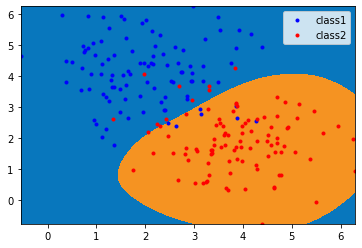

In [19]:
x_r = [min(data[:,0]), max(data[:,0])]
y_r = [min(data[:,1]), max(data[:,1])]
set_sklearn_backgound(l1ksvm, x_r, y_r)
plt.xlim(x_r)
plt.ylim(y_r)
t = np.linspace(start=min(data[:,0]), stop = max(data[:,0]), num=50)
plt.plot(data1[:,0], data1[:,1], 'b.', label="class1")
plt.plot(data2[:,0], data2[:,1], 'r.', label="class2")
plt.legend()
plt.show()
plt.close()

# L2-SVM(非線形 : カーネル法)

In [20]:
class L2KSVM(object):
    def __init__(self, C=10, kernel='lienar', d=2, gamma=3.0):
        self.C = C
        self.kernel = kernel
        self.d = d
        self.gamma=gamma

        cvxopt.solvers.options['abstol']=1e-15
        cvxopt.solvers.options['reltol']=1e-15
        cvxopt.solvers.options['feastol']=1e-15
        cvxopt.solvers.options['maxiters']=500
        
    def _set_kernel(self, X, Y=None):
        if(self.kernel=='rbf'):
            return rbf_kernel(X,Y,gamma=self.gamma)
        elif(self.kernel=='poly'):
            return polynomial_kernel(X,Y,degree=self.d, gamma=1, coef0=1)
        else:
            return linear_kernel(X,Y)
        
    def fit(self, train_X, train_Y):
        #内積行列を作成
        #内積行列を作成
        K = self._set_kernel(train_X)+np.identity(train_X.shape[0])/self.C
        self.train_X=train_X
        self.train_Y=train_Y
        
        #cvxopt用の変数
        P = matrix(K*train_Y.reshape(1,-1)*train_Y.reshape(-1,1), K.shape ,'d')
        q = matrix((-1)*np.ones(K.shape[0]).reshape(-1,1),(K.shape[0],1) ,'d')
        A = matrix(train_Y.reshape(1,-1),(1,K.shape[0]),'d')
        b = matrix(np.array([0]),(1,1),'d')
        G1 = (-1)*np.identity(K.shape[0])
        h1 = np.zeros(K.shape[0]).reshape(-1,1)
        
        G = matrix(G1,(K.shape[0], K.shape[0]), 'd')
        h = matrix(h1,(K.shape[0],1),'d')

        self.sol = cvxopt.solvers.qp(P=P, q=q, A=A, b=b, G=G, h=h)
        self.alpha = np.array(self.sol['x']).reshape(-1)
        if(self.C > 1):
            idx = np.where(self.alpha<1e-3)
        else:
            idx = np.where(self.alpha<self.C*1e-4)
        self.alpha[idx] = 0
        self.sv_index = np.where(self.alpha>0)
        self.sv = train_X[self.sv_index]
        self.sv_label = train_Y[self.sv_index]
        self.b = np.sum(train_Y.reshape(-1,1)-(K*self.train_Y.reshape(1,-1))@self.alpha.reshape(-1,1), axis=0)/len(train_Y)
        
    def decision_function(self,X):
        return (self._set_kernel(X, self.train_X)*self.train_Y.reshape(1,-1))@self.alpha.reshape(-1,1) +np.ones((X.shape[0],1))*self.b
    
    def predict(self, X):
        D = self.decision_function(X)
        predict_y = np.ones(X.shape[0])
        predict_y[D.reshape(-1)<0]=-1
        return predict_y
    
    def score(self, X, Y):
        predict_y = self.predict(X)
        return 100*np.sum(Y==predict_y)/len(Y)

In [21]:
#学習
l2ksvm = L2KSVM(kernel='rbf', gamma=1, C=0.01)
l2ksvm.fit(data, y)
print(f'score : {l2ksvm.score(data,y)}%')

     pcost       dcost       gap    pres   dres
 0: -8.6430e-01 -2.5841e+00  2e+00  3e-16  1e+00
 1: -8.6436e-01 -8.8281e-01  2e-02  3e-16  1e-02
 2: -8.6437e-01 -8.6455e-01  2e-04  5e-16  1e-04
 3: -8.6437e-01 -8.6437e-01  2e-06  5e-16  1e-06
 4: -8.6437e-01 -8.6437e-01  2e-08  6e-16  1e-08
 5: -8.6437e-01 -8.6437e-01  2e-10  7e-16  1e-10
 6: -8.6437e-01 -8.6437e-01  2e-12  3e-16  1e-12
 7: -8.6437e-01 -8.6437e-01  2e-14  5e-16  1e-14
 8: -8.6437e-01 -8.6437e-01  2e-16  1e-16  2e-16
Optimal solution found.
score : 91.5%


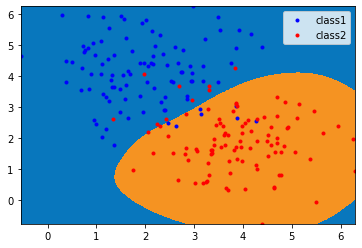

In [22]:
x_r = [min(data[:,0]), max(data[:,0])]
y_r = [min(data[:,1]), max(data[:,1])]
set_sklearn_backgound(l2ksvm, x_r, y_r)
plt.xlim(x_r)
plt.ylim(y_r)
t = np.linspace(start=min(data[:,0]), stop = max(data[:,0]), num=50)
plt.plot(data1[:,0], data1[:,1], 'b.', label="class1")
plt.plot(data2[:,0], data2[:,1], 'r.', label="class2")
plt.legend()
plt.show()
plt.close()

# Support Vector Data Discription (SVDD)

SVDDでは正常データのみを用いて以下の最適化問題により超球の原点と半径を求める.

\begin{align}
&\mathrm{max}\quad \sum_{i=1}^M K(x_i, x_i) - \sum_{i,j=1}^M \alpha_i \alpha_j K(x_i, x_j)\\
&\mathrm{s.t.}\quad \sum_{i=1} \alpha_i=1,\quad 0\leq \alpha_i \leq C
\end{align}

求めた$\alpha = (\alpha_1, \cdots. \alpha_M)$を用いて,未知のデータ$x$に対して以下の基準により異常を検出する.

\begin{align}
K(x, x) -2\sum_{i\in S} \alpha_i K(x, x_i) +\sum_{i\in S\\ j \in S} \alpha_i \alpha_j K(x_i, x_j) \leq R^2
\end{align}
ここで, 半径$R$は, 上限に達していないサポートベクトル$x_i$に対して,

\begin{align}
&R^2 = \frac{1}{|S|} \sum_{i \in S} \|\phi(x_i)-a\|^2 \\
&a = \sum_{i=1}^M \alpha_i \phi(x_i)
\end{align}
により得られる.

In [23]:
class SVDD(object):
    def __init__(self, C=10, kernel='lienar', d=2, gamma=3.0):
        self.C = C
        self.kernel = kernel
        self.d = d
        self.gamma=gamma
        
        cvxopt.solvers.options['abstol']=1e-15
        cvxopt.solvers.options['reltol']=1e-15
        cvxopt.solvers.options['feastol']=1e-15
        cvxopt.solvers.options['maxiters']=500
        
    def _set_kernel(self, X, Y=None):
        if(self.kernel=='rbf'):
            return rbf_kernel(X,Y,gamma=self.gamma)
        elif(self.kernel=='poly'):
            return polynomial_kernel(X,Y,degree=self.d, gamma=1, coef0=1)
        else:
            return linear_kernel(X,Y)
    
    def _daig_kernel(self, X):
        K = []
        for i in range(X.shape[0]):
            K.append(self._set_kernel(X[i].reshape(1,-1)))
        return np.array(K)
            
        
    def fit(self, train_X):
        #内積行列を作成
        K = self._set_kernel(train_X)
        self.train_X=train_X
        
        #cvxopt用の変数
        P = matrix(2*K, K.shape, 'd')
        q = matrix(np.diag(K).reshape(-1,1), (K.shape[0],1), 'd')
        A = matrix(np.ones(K.shape[0]).reshape(1,-1),(1,K.shape[0]),'d')
        b = matrix(np.array([1]),(1,1),'d')
        G1 = (-1)*np.identity(K.shape[0])
        h1 = np.zeros(K.shape[0]).reshape(-1,1)
        G2 = np.identity(K.shape[0])
        h2 = self.C*np.ones(K.shape[0]).reshape(-1,1)
        G = matrix(np.r_[G1, G2],(2*K.shape[0], K.shape[0]), 'd')
        h = matrix(np.r_[h1, h2],(2*K.shape[0],1),'d')

        self.sol = cvxopt.solvers.qp(P=P, q=q, A=A, b=b, G=G, h=h)
        self.alpha = np.array(self.sol['x']).reshape(-1)
        if(self.C > 1):
            idx = np.where(self.alpha<1e-3)
        else:
            idx = np.where(self.alpha<self.C*1e-4)
        self.alpha[idx] = 0
        self.sv_index = np.where(self.alpha>0)
        self.sv = train_X[self.sv_index]
        self.norm_a = self.alpha.reshape(1,-1)@K@self.alpha.reshape(-1,1)
        
    def decision_function(self,X):
        test_Kii = self._daig_kernel(X)
        test_K = self._set_kernel(X, self.train_X)
        return test_Kii.reshape(-1,1)-2*test_K@self.alpha.reshape(-1,1)-self.norm_a
    
    def predict(self,X):
        #print(X.shape)
        return self.decision_function(X)

In [24]:
#学習
svdd = SVDD(C=1e-2, kernel='lienar', d=2, gamma=3.0)
normal_idx = np.where(y==-1)
svdd.fit(data[normal_idx])

     pcost       dcost       gap    pres   dres
 0: -1.9695e+02 -3.7635e+01  3e+03  6e+01  2e-15
 1: -4.6191e+01 -3.4102e+01  2e+02  4e+00  2e-15
 2: -3.4367e+01 -1.0029e+01  1e+02  2e+00  1e-15
 3: -8.0631e+00  2.0325e+01  9e+01  1e+00  1e-15
 4:  2.5934e+01  2.9933e+01  2e+01  2e-01  8e-16
 5:  2.9697e+01  3.0943e+01  2e+01  1e-01  6e-16
 6:  3.4192e+01  3.4787e+01  5e+00  4e-02  7e-16
 7:  3.5118e+01  3.5754e+01  4e+00  3e-02  7e-16
 8:  3.5968e+01  3.6573e+01  3e+00  2e-02  7e-16
 9:  3.6576e+01  3.7005e+01  3e+00  1e-02  8e-16
10:  3.7087e+01  3.7352e+01  3e+00  1e-02  8e-16
11:  3.7537e+01  3.7675e+01  2e+00  9e-03  8e-16
12:  3.7800e+01  3.7791e+01  2e+00  7e-03  8e-16
13:  3.8160e+01  3.8022e+01  1e+00  5e-03  9e-16
14:  3.8378e+01  3.8152e+01  1e+00  3e-03  9e-16
15:  3.8637e+01  3.8601e+01  1e-01  3e-04  1e-15
16:  3.8652e+01  3.8652e+01  1e-03  3e-06  8e-16
17:  3.8653e+01  3.8653e+01  1e-05  3e-08  8e-16
18:  3.8653e+01  3.8653e+01  1e-07  3e-10  8e-16
19:  3.8653e+01  3.86

In [25]:
def svdd_set_sklearn_backgound(cls, x_r, y_r):
    N = 1000

    #color_map = LinearSegmentedColormap.from_list("color_map", [
    #        (0.0, "#f59322"),
    #        (0.5, "#ffffff"),
    #        (1.0, "#0877bd"),])
    color_map = 'coolwarm_r'
    
    X, Y = np.meshgrid(np.linspace(*x_r, N), np.linspace(*y_r, N))
    X = np.hstack(X)
    Y = np.hstack(Y)
    Z=np.dstack((X, Y)).reshape(-1, 2)
    Z = cls.predict(Z).reshape(N,N)
    X = X.reshape((N, -1))
    Y = Y.reshape((N, -1))

    plt.pcolor(X, Y, Z, cmap=color_map)

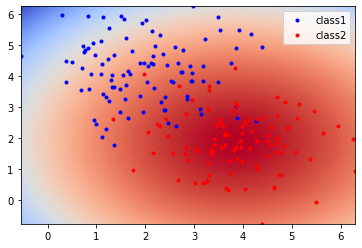

In [26]:
x_r = [min(data[:,0]), max(data[:,0])]
y_r = [min(data[:,1]), max(data[:,1])]
svdd_set_sklearn_backgound(svdd, x_r, y_r)
plt.xlim(x_r)
plt.ylim(y_r)
t = np.linspace(start=min(data[:,0]), stop = max(data[:,0]), num=50)
plt.plot(data1[:,0], data1[:,1], 'b.', label="class1")
plt.plot(data2[:,0], data2[:,1], 'r.', label="class2")
plt.legend()
plt.show()
plt.close()

# SSAD (Semi-Supervised Anomaly Detection)

SSADでは, 正常/異常のラベル付きデータと正常と仮定できるラベル無しデータによりSVDDを半教師あり手法に拡張する.

以下では, ラベル無しデータを使わずに正常/異常のラベル付きデータのみにより, 超球を求める.

\begin{align}
&\mathrm{max}\quad -\frac{1}{2}\alpha^\top \hat{K} \alpha \\
&\mathrm{s.t.}\quad 0\leq \alpha_i \leq C,\quad \kappa\leq\sum_{i=1}^M \alpha_i,\quad \sum_{i=1}^M \alpha_i y_i =1
\end{align}
ただし, $\hat{K}=\{y_i y_j K(x_i, x_j)\}$である

求めた$\alpha = (\alpha_1, \cdots. \alpha_M)$を用いて,未知のデータ$x$に対して以下の基準により異常を検出する.
\begin{align}
&D(x) = w^\top \phi(x) - \tau\\
&w = \sum_{i \in S} \alpha_i y_i \phi(x_i)
\end{align}
SSADでは$K(x,x)=1$を満たすカーネル, 例えばRBFカーネルなどを使う必要がある.

In [27]:
class SSAD(object):
    def __init__(self, kernel='gamma', d=2, gamma=3.0, C=10, kappa=1.0):
        self.C = C
        self.kernel = kernel
        self.d = d
        self.gamma=gamma
        self.kappa = kappa
        
        cvxopt.solvers.options['abstol']=1e-15
        cvxopt.solvers.options['reltol']=1e-15
        cvxopt.solvers.options['feastol']=1e-15
        cvxopt.solvers.options['maxiters']=500
        
    def _set_kernel(self, X, Y=None):
        if(self.kernel=='rbf'):
            return rbf_kernel(X,Y,gamma=self.gamma)
        elif(self.kernel=='poly'):
            return polynomial_kernel(X,Y,degree=self.d, gamma=1, coef0=1)
        else:
            return linear_kernel(X,Y)
    
    def _daig_kernel(self, X):
        K = []
        for i in range(X.shape[0]):
            K.append(self._set_kernel(X[i].reshape(1,-1)))
        return np.array(K)
            
        
    def fit(self, train_X, train_Y):
        #train_Y = {+1 or -1} 
        #内積行列を作成
        self.y = train_Y
        K = self._set_kernel(train_X)*self.y.reshape(1,-1)*self.y.reshape(-1,1)
        self.train_X=train_X
        
        #cvxopt用の変数
        P = matrix(K, K.shape, 'd')
        q = matrix(0.0, (K.shape[0],1), 'd')
        
        A = matrix(self.y.reshape(1,-1),(1,len(y)),'d')
        b = matrix(np.array([1]),(1,1),'d')
        
        G1 = (-1)*np.identity(K.shape[0])
        h1 = np.zeros(K.shape[0]).reshape(-1,1)
        G2 = np.identity(K.shape[0])
        h2 = self.C*np.ones(K.shape[0]).reshape(-1,1)
        G3 = np.ones(K.shape[0]).reshape(1,-1)
        h3 = np.array([self.kappa]).reshape(1,1)
        G = matrix(np.r_[G1, G2, G3],(2*K.shape[0]+1, K.shape[0]), 'd')
        h = matrix(np.r_[h1, h2, h3],(2*K.shape[0]+1,1),'d')

        self.sol = cvxopt.solvers.qp(P=P, q=q, A=A, b=b, G=G, h=h)
        self.alpha = np.array(self.sol['x']).reshape(-1)
        if(self.C > 1):
            idx = np.where(self.alpha<1e-3)
        else:
            idx = np.where(self.alpha<self.C*1e-4)
        self.alpha[idx] = 0
        self.sv_index = np.where(self.alpha>0)
        self.sv = train_X[self.sv_index]
        self.threshold = 0.0
        D = self.decision_function(train_X)
        pidx = np.where(train_Y==1)
        nidx = np.where(train_Y==-1)
        p = np.max(D[pidx])
        n = np.min(D[nidx])
        self.threshold = (p+n)/2
        
    def decision_function(self,X):
        test_K = self._set_kernel(X, self.train_X)
        return self.y.reshape(1,-1)*test_K@self.alpha-self.threshold
    
    def predict(self,X):
        #print(X.shape)
        return self.decision_function(X)

In [28]:
#学習
ssad = SSAD(C=1e-2, kernel='rbf', d=2, gamma=3.0, kappa=1.0)
ssad.fit(data, y)

     pcost       dcost       gap    pres   dres
 0:  2.1554e-02 -2.0126e+00  4e+02  2e+01  1e+01
 1:  1.9732e-02 -1.9835e+00  1e+01  4e-01  3e-01
 2:  3.3900e-02 -8.6885e-01  1e+00  2e-02  1e-02
 3:  3.8512e-02 -9.8643e-03  6e-02  7e-04  5e-04
 4:  3.8640e-02  3.8150e-02  6e-04  7e-06  5e-06
 5:  3.8641e-02  3.8636e-02  6e-06  7e-08  5e-08
 6:  3.8641e-02  3.8641e-02  6e-08  7e-10  5e-10
 7:  3.8641e-02  3.8641e-02  6e-10  7e-12  5e-12
 8:  3.8641e-02  3.8641e-02  6e-12  7e-14  5e-14
 9:  3.8641e-02  3.8641e-02  6e-14  1e-15  1e-14
10:  3.8641e-02  3.8641e-02  7e-15  3e-16  6e-15
11:  3.8641e-02  3.8641e-02  6e-15  4e-16  8e-15
12:  3.8641e-02  3.8641e-02  1e-15  3e-16  2e-14
13:  3.8641e-02  3.8641e-02  2e-16  2e-16  1e-13
14:  3.8641e-02  3.8641e-02  2e-16  3e-16  2e-13
15:  3.8641e-02  3.8641e-02  3e-17  2e-16  4e-11
16:  3.8641e-02  3.8641e-02  1e-18  2e-16  7e-11
17:  3.8641e-02  3.8641e-02  1e-20  4e-17  1e-09
18:  3.8641e-02  3.8641e-02  2e-22  3e-17  2e-08
19:  3.8641e-02  3.86

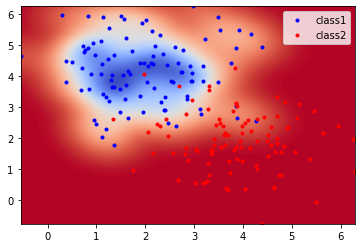

In [29]:
x_r = [min(data[:,0]), max(data[:,0])]
y_r = [min(data[:,1]), max(data[:,1])]
svdd_set_sklearn_backgound(ssad, x_r, y_r)
plt.xlim(x_r)
plt.ylim(y_r)
t = np.linspace(start=min(data[:,0]), stop = max(data[:,0]), num=50)
plt.plot(data1[:,0], data1[:,1], 'b.', label="class1")
plt.plot(data2[:,0], data2[:,1], 'r.', label="class2")
plt.legend()
plt.show()
plt.close()